# Feedforward inhibition

In this _in silico_ experiment, we will analyze the effect of feedforward inhibition (FFI) mediated by the Schaffer collaterals (SC)—axons from CA3 pyramidal cells that innervate neurons in the CA1 region. The microcircuit consists of one pyramidal cell (PC), sampled from the middle of the rCA1-CYLINDER-REF, and eight parvalbumin-positive (PV+) interneurons converging onto the PC. The circuit also includes SC fibers that provide input to all nine neurons.

We previously ran two simulations: a control condition (with FFI) and a condition in which inhibition was blocked (without FFI). In both cases, we stimulated an increasing number of SC fibers (50, 100... 1300) with a single synchronous input (delay between stimuly of 100 ms). To estimate the spike probability of the postsynaptic PC, each simulation was repeated 10 times.

![SETUP](ffi_setup.png)

In [1]:
import bluepysnap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Loading
In this case, we have to compare two simulations, so we need two paths.

In [2]:
simulation_root = "/Users/armando/Desktop/Models/simulations/N_9__rCA1-ThetaOsc-Sel1__swc/ffi/"
simulation_root2 = "/Users/armando/Desktop/Models/simulations/N_9__rCA1-ThetaOsc-Sel1__swc/ffi_no_inh/"

In [3]:
simulation_path = simulation_root + "simulation_config.json"
simulation_path2 = simulation_root2 + "simulation_config.json"

In [4]:
simulation = bluepysnap.Simulation(simulation_path)
simulation2 = bluepysnap.Simulation(simulation_path2)

Parameters of the input were previously saved in a json file. We can load it to fetch these parameters which will be useful for the analysis

In [7]:
filename = "./parameters.json"

with open(filename, "r") as file:
    parameters = json.load(file)

In [8]:
n_repetition = parameters["n_repetition"]
delay = parameters["delay"]
n_fibers = parameters["n_fibers"]
t_start = parameters["t_start"]

## Access spike times
We can access the spike times from the two circuit simulations

In [4]:
spikes = simulation.spikes
spikes2 = simulation2.spikes

NameError: name 'simulation' is not defined

Visualize details of the spike times

In [ ]:
print(
    spikes.time_start, 
    spikes.time_stop, 
    spikes.dt
)

In [9]:
spikes.population_names

['hippocampus_neurons']

In [10]:
spike_pop = spikes['hippocampus_neurons']

In [11]:
ids = spike_pop.node_ids
node_population = spike_pop.nodes
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
node_ids,,,,,
0,SP,EXC,2614.981470,443.526012,4360.400973
1,SP,INH,2448.882424,420.070191,4545.937066
2,SP,INH,2383.241273,407.206940,4348.334404
3,SP,INH,2757.379176,528.859665,4458.257239
4,SP,INH,2504.818178,439.365759,4423.936844


We are interested only in the excitatory cells, i.e. pyramidal cells, to compute the input-output of the small microcircuit

In [12]:
filtered = spikes.filter(group={'synapse_class':'EXC'})
filtered2 = spikes2.filter(group={'synapse_class':'EXC'})

In [13]:
spike_times = filtered.report.index.values
spike_times2 = filtered2.report.index.values

We calculate the probability of spiking given the amount of stimulated fibers. For a given number of stimulated fibers, the pyramidal cell can fire only in a subset of repetition. The ratio between the times it spikes over the number of repetition is an estimation of the spike probability.

In [14]:
df = pd.DataFrame(columns=['fibers', 'ffi', 'no_ffi'])

In [15]:
t = t_start

for i, fibers in enumerate(n_fibers):
    events = 0
    events2 = 0
    for _idx in np.arange(n_repetition):
        if ((spike_times > t) & (spike_times < t + delay)).any():
            events += 1
        if ((spike_times2 > t) & (spike_times2 < t + delay)).any():
            events2 += 1        
        t += delay
    prob = events / n_repetition
    prob2 = events2 / n_repetition
    df.loc[i] = fibers, prob, prob2
df

,fibers,ffi,no_ffi
0,50.0,0.0,0.0
1,100.0,0.0,0.0
2,150.0,0.0,0.0
3,200.0,0.0,0.0
4,250.0,0.1,0.1
5,300.0,0.0,0.0
6,350.0,0.0,0.1
7,500.0,0.5,0.5
8,700.0,0.8,0.8
9,900.0,1.0,1.0


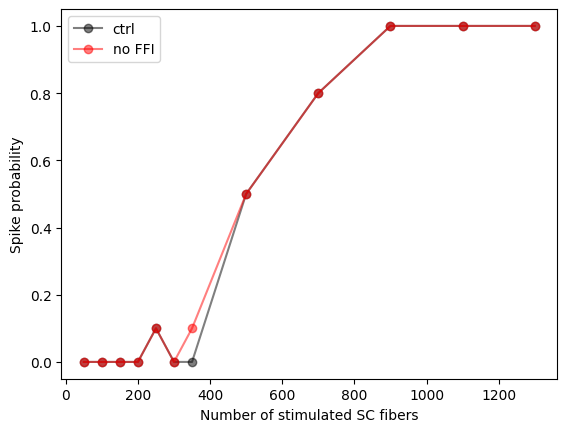

In [16]:
fig, ax = plt.subplots()

x = df['fibers'].values
y = df['ffi'].values
y2 = df['no_ffi'].values

ax.plot(x, y, '-ok', alpha=0.5, label='ctrl')
ax.plot(x, y2, '-or', alpha=0.5, label='no FFI')

ax.set_xlabel('Number of stimulated SC fibers')
ax.set_ylabel('Spike probability')

plt.legend(loc='best')

fig.show()

## Discussion
In the simulations above, we can appreciate an effect of inhibition but it is too small compared to experimental measures of FFI. While this result might be disappointing for some of you, we can be explained in two ways. First, despite all the efforts invested in Romani et al. (2024), the experimental data were not sufficient to constrained SC correctly. Second, the FFI is a phenomenon which emerges at network level when a "critical mass" of neurons is present.

## References
Romani A, Antonietti A, Bella D, Budd J, Giacalone E, Kurban K, Sáray S, Abdellah M, Arnaudon A, Boci E, Colangelo C, Courcol JD, Delemontex T, Ecker A, Falck J, Favreau C, Gevaert M, Hernando JB, Herttuainen J, Ivaska G, Kanari L, Kaufmann AK, King JG, Kumbhar P, Lange S, Lu H, Lupascu CA, Migliore R, Petitjean F, Planas J, Rai P, Ramaswamy S, Reimann MW, Riquelme JL, Román Guerrero N, Shi Y, Sood V, Sy MF, Van Geit W, Vanherpe L, Freund TF, Mercer A, Muller E, Schürmann F, Thomson AM, Migliore M, Káli S, Markram H. Community-based reconstruction and simulation of a full-scale model of the rat hippocampus CA1 region. PLoS Biol. 2024 Nov 5;22(11):e3002861. doi: 10.1371/journal.pbio.3002861. PMID: 39499732; PMCID: PMC11537418.
https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3002861